In [1]:
import pandas as pd
import folium
import folium.plugins
import warnings
warnings.filterwarnings('ignore')

# WA Crash Viz and Analysis
### By Katharine Chen, Tianqi Fang, Yutong Liu, Shuyi Yin

## Problem Background

+ Broad variety of factors (environmental, physical, etc) that contribute to a road’s overall safety;<br>
+ Important for general users, in addition to administrative/government officials, to be able to assess road conditions easily in a user-friendly interface;

## Use case

+ Average driver may consult the map and analysis before travel;<br>
+ DOT planners, police officers and other professionals may look deeper into contributing factors;<br>
+ They are all **non-programmers** and thus need an interactive environment that visualize past accidents and tell them what factors contribute most to crashes;<br>
+ ***Rainy day, steep downhill curved road, old car, young driver;***

## Python Libraries:
+ Folium;
+ Bokeh;
+ Matplotlib;

## Folium simple example

### Data cleaning

In [2]:
def clean(source, sink):
    df = pd.read_csv(source)
    df = df.dropna()
    df.to_csv(sink)
    pass

In [3]:
# use case:
clean("coords.csv", "coords_cleaned.csv")

### Mapping

#### Load datasets with Pandas

In [2]:
def readCleanLoc(source):
    '''
    @param source: cleaned csv file of lat/lons
    @use case: df_cleaned = readLoc("coords_gps.csv")
    '''
    # read from file
    df_cleaned = pd.read_csv(source)
    
    # change column name
    df_cleaned.columns = ['lat', 'lon']
    
    # assert no nan after cleaning
    assert not df_cleaned.isnull().values.any()
    return df_cleaned

In [3]:
def readOrig(origSource, cleanLocSource):
    '''
    @param origSource: original dataset file
    @param cleanLocSource: cleaned lat/lon file
    @use case: df = readOrig("WA_Rural_St_RtesCrashes_Full.csv")
    '''

    # read
    df = pd.read_csv(origSource)
    
    # select columns
    columns = ['DATE',
               'PRIMARY TRAFFICWAY',
               'MILEPOST',
               '# INJ',
               '# FAT',
               'WA STATE PLANE SOUTH - X 2010 - FORWARD',
               'WA STATE PLANE SOUTH - Y 2010 - FORWARD']
    df = df[columns]
    
    # drop rows that have nan in defined columns
    df = df.dropna(subset=['WA STATE PLANE SOUTH - X 2010 - FORWARD',
                      'WA STATE PLANE SOUTH - Y 2010 - FORWARD'])
    
    # must collapse index
    df = df.reset_index(drop=True)
    
    # transform time
    df['date'] = pd.to_datetime(df['DATE'])
    df['year'] = df['date'].dt.year
    
    columns = ['PRIMARY TRAFFICWAY',
               'MILEPOST',
               '# INJ',
               '# FAT',
               'WA STATE PLANE SOUTH - X 2010 - FORWARD',
               'WA STATE PLANE SOUTH - Y 2010 - FORWARD',
               'year']
    df = df[columns]
    
    # change columns name
    df.columns = ['PRIMARY TRAFFICWAY',
                  'MILEPOST',
                  '# INJ',
                  '# FAT',
                  'lat',
                  'lon',
                  'year']
    
    # update lat lon
    df_cleaned = readCleanLoc(cleanLocSource)
    df.lat = df_cleaned.lat
    df.lon = df_cleaned.lon
    
    # assert no nan
    assert not df.isnull().values.any()
    assert not df_cleaned.isnull().values.any()

    return df

#### Plot with Folium

In [11]:
def plotMap(origFile, cleanLoc, mapSink, start, end):
    '''
    @param origFile: original dataset file
    @param cleanLoc: cleaned lat/lon file
    @param mapSink: saving destination of generated map
    '''

    # read data
    df = readOrig(origFile, cleanLoc)
    
    # create map object
    accWA = folium.Map([df.lat.median(), df.lon.median()],
                   # tiles="cartodbpositron",
                   tiles = '',
                   # width='80%',
                   # height='80%',
                   prefer_canvas=True,
                   zoom_start=7)
    # add tile layer
    folium.TileLayer('cartodbpositron', name = 'bright').add_to(accWA)
    folium.TileLayer('CartoDB dark_matter', name = 'dark').add_to(accWA)
    
    # create crash layer
    crashes = []
    clusters = []
    for year in range(start, end + 1):
        
        # create cluster layer
        yrClust = folium.FeatureGroup(name=str(year) + '_Clusters', show=False)
        clusters.append(yrClust)
        accWA.add_child(clusters[-1])

        # add cluster layer to feature group
        marClst = folium.plugins.FastMarkerCluster(
            data=list(zip(df[df['year'] == year]['lat'].values, df[df['year'] == year]['lon'].values))
        ).add_to(clusters[-1])
        
        # individual crashes
        yrCrash = folium.FeatureGroup(name=str(year) + '_Crashes', show=False)
        crashes.append(yrCrash)
        accWA.add_child(crashes[-1])
        
        # add crashe events to their layers
        for _, row in df[df['year'] == year].iterrows():
            folium.CircleMarker([row['lat'], row['lon']],
                          radius=max((row['# INJ'] + row['# FAT']), 1),
                          popup="Occured at: {}\nwith {} INJ and {} FAT".format(
                              row['PRIMARY TRAFFICWAY'], row['# INJ'], row['# FAT']),
                          # fill_color="#3db7e4",
                          color="#007849",
                          fill=False
                         ).add_to(crashes[-1])
    
        

    # add layer control
    folium.LayerControl().add_to(accWA)
            
    # save map
    accWA.save(mapSink)
    
    return accWA

In [ ]:
_ = plotMap("WA_Rural_St_RtesCrashes_Full.csv",
            "coords_gps.csv",
            "folium_year.html",
            2010, 2017)

##### View the Crashes By Year plot [here](https://syin3.github.io/WA-Crash-Viz-and-Analysis/folium_year.html).<br>
##### View the Crashes By County plot [here](https://syin3.github.io/WA-Crash-Viz-and-Analysis/folium_county.html).<br>

## Bokeh simple example

## Matplotlib simple example

## Comparison of Folium vs. Bokeh vs. Matplotlib

In [8]:
%%html
<style>
table {float:left}
</style> 

| Folium | Bokeh | Matplotlib |
| :---: | :---: | :---: |
| <font color='red'>Interactive</font> | <font color='red'>Interactive</font> | <font color='steelblue'>Static</font> |
| <font color='red'>Higher capacity</font> | <font color='steelblue'>Lower capacity</font> | <font color='steelblue'>Static</font> |

## Thanks! Q&A time

## Aggregate by year

In [ ]:
df = pd.read_csv("WA_Rural_St_RtesCrashes_Full.csv")
df['date'] = pd.to_datetime(df['DATE'])

In [29]:
df['year'] = df['date'].dt.year
df.groupby(['year']).agg(['count'])

,JURISDICTION,COUNTY,CITY,PRIMARY TRAFFICWAY,MILEPOST,A/B,SR ONLY HISTORY / SUSPENSE IND,REPORT NUMBER,DATE,TIME,...,BICYCLIST CONTRIBUTING CIRCUMSTANCE 1 (UNIT 2),BICYCLIST CONTRIBUTING CIRCUMSTANCE 2 (UNIT 2),BICYCLIST CONTRIBUTING CIRCUMSTANCE 3 (UNIT 2),PEDESTRIAN CONTRIBUTING CIRCUMSTANCE 1 (UNIT 2),PEDESTRIAN CONTRIBUTING CIRCUMSTANCE 2 (UNIT 2),PEDESTRIAN CONTRIBUTING CIRCUMSTANCE 3 (UNIT 2),"FIRST IMPACT LOCATION (City, County & Misc Trafficways - 2010 forward)",WA STATE PLANE SOUTH - X 2010 - FORWARD,WA STATE PLANE SOUTH - Y 2010 - FORWARD,date
,count,count,count,count,count,count,count,count,count,count,...,count,count,count,count,count,count,count,count,count,count
year,,,,,,,,,,,,,,,,,,,,,
2007,10883,10883,3890,10883,10883,77,10883,10883,10883,10883,...,24,1,0,63,6,1,10883,0,0,10883
2008,10431,10431,3648,10431,10431,77,10431,10431,10431,10431,...,25,1,0,76,9,3,10431,6,6,10431
2009,10074,10074,3567,10074,10074,60,10074,10074,10074,10074,...,38,5,0,55,2,0,10074,29,29,10074
2010,9962,9962,3595,9962,9962,61,9962,9962,9962,9962,...,37,1,0,71,3,0,9962,9927,9927,9962
2011,9668,9668,3328,9668,9668,75,9668,9668,9668,9668,...,42,2,0,77,4,0,9668,9643,9643,9668
2012,9993,9993,3472,9993,9993,77,9993,9993,9993,9993,...,36,3,0,79,5,0,9993,9992,9992,9993
2013,9532,9532,3460,9532,9532,70,9532,9532,9532,9532,...,43,6,2,68,9,0,9532,9532,9532,9532
2014,10405,10405,3680,10405,10405,74,10405,10405,10405,10405,...,49,11,6,71,5,1,10405,10405,10405,10405


### Num of cases across years

In [30]:
df['year'].value_counts()

2016    12025
2017    11838
2015    11284
2007    10883
2008    10431
2014    10405
2009    10074
2012     9993
2010     9962
2011     9668
2013     9532
Name: year, dtype: int64

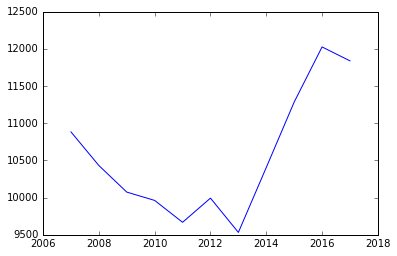

In [36]:
from matplotlib import pyplot as plt
plt.plot(df['year'].value_counts().sort_index())
plt.show()